Import Libraries

In [18]:
import warnings, io, csv, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, cross_validate, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, f1_score, classification_report,
                             confusion_matrix, roc_auc_score, roc_curve,
                             precision_recall_curve, average_precision_score)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from joblib import dump

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Suppress warnings
warnings.filterwarnings("ignore")

# Set random state for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

Load and Prepare Data

This cell is modified to load your specific CSV and rename the columns to the standardized date and close that the rest of the script expects.

In [10]:
CSV_PATH = "../1 data acqusition/Antam_historical_gold_prices.csv"

try:
    df = pd.read_csv(CSV_PATH)
except FileNotFoundError:
    print(f"Error: File not found at {CSV_PATH}")
    df = pd.DataFrame() # Create empty dataframe to avoid further errors

if not df.empty:
    # --- Data Standardization ---
    # Rename your columns to the standard names used by the feature functions
    rename_map = {
        'Date': 'date',
        'Gold Price': 'close',
        'Time (ms)': 'time_ms' # Keep this column if you want, but we'll drop it later
    }
    df = df.rename(columns=rename_map)

    # Convert 'date' column to datetime objects
    df['date'] = pd.to_datetime(df['date'])
    
    # Sort by date, which is crucial for time-series features
    df = df.sort_values(by='date').reset_index(drop=True)
    
    # Select only the columns we need for the rest of the script
    df = df[['date', 'close']]

    print("--- Data Loaded and Standardized ---")
    print(f"Data shape: {df.shape}")
    print(df.head())
    print("\n")
    df.info()

--- Data Loaded and Standardized ---
Data shape: (4838, 2)
                 date   close
0 2010-01-04 09:07:00  408000
1 2010-01-05 09:28:00  410000
2 2010-01-06 07:01:00  410000
3 2010-01-07 09:45:00  412000
4 2010-01-08 09:37:00  410000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4838 entries, 0 to 4837
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    4838 non-null   datetime64[ns]
 1   close   4838 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 75.7 KB


Exploratory Data Analysis (EDA)

Plot the price over time and the distribution of daily returns.

Date range: 2010-01-04 09:07:00 → 2025-10-07 08:02:15


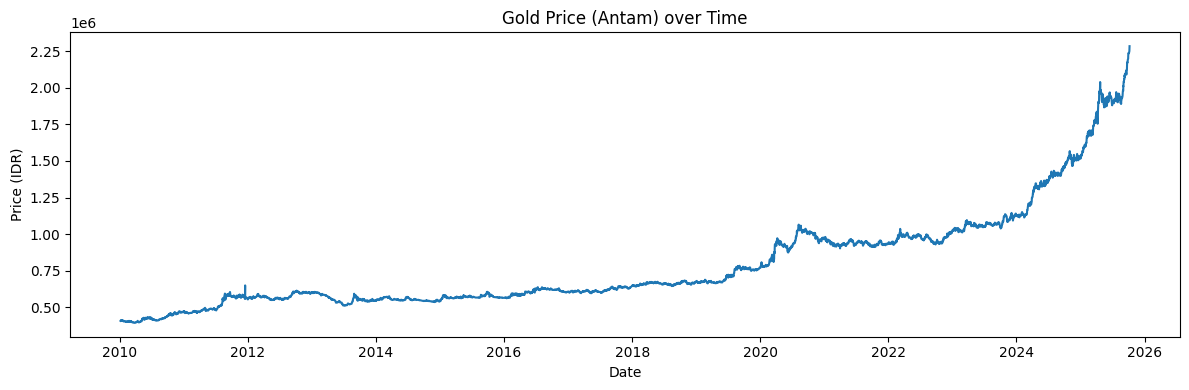

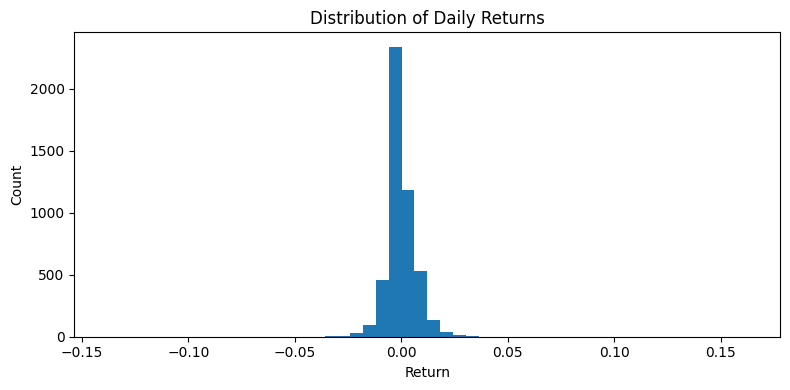

In [11]:
if not df.empty:
    print(f"Date range: {df['date'].min()} → {df['date'].max()}")

    # Plot price over time
    plt.figure(figsize=(12,4))
    plt.plot(df['date'], df['close'])
    plt.title("Gold Price (Antam) over Time")
    plt.xlabel("Date")
    plt.ylabel("Price (IDR)")
    plt.tight_layout()
    plt.savefig("gold_price_over_time.png")
    plt.show()

    # Calculate and plot returns
    df['ret'] = df['close'].pct_change()
    plt.figure(figsize=(8,4))
    plt.hist(df['ret'].dropna(), bins=50)
    plt.title("Distribution of Daily Returns")
    plt.xlabel("Return")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig("gold_returns_distribution.png")
    plt.show()

Feature Engineering

This function (copied from your template) creates technical indicators (RSI, MACD, Bollinger Bands), rolling statistics, and calendar features.

In [19]:
def add_features_adaptive(data: pd.DataFrame, price='close') -> pd.DataFrame:
    out = data.copy()
    n = len(out)

    if n < 8:
        raise ValueError(f"Dataset too small after loading (n={n}). Add more rows.")

    out['ret'] = out[price].pct_change()
    out['log_ret'] = np.log1p(out['ret'])

    # Choose lags/windows based on data length
    max_lag = max(1, min(5, n // 6))
    lag_list = list(range(1, max_lag + 1))
    win_candidates = [3, 5, 10, 20]
    win_list = [w for w in win_candidates if w < n-2]
    if not win_list:
        win_list = [3]  # minimal

    for L in lag_list:
        out[f'ret_lag_{L}'] = out['ret'].shift(L)

    for w in win_list:
        out[f'roll_mean_{w}'] = out['ret'].rolling(w, min_periods=1).mean()
        out[f'roll_std_{w}']  = out['ret'].rolling(w, min_periods=1).std()
        out[f'roll_min_{w}']  = out['ret'].rolling(w, min_periods=1).min()
        out[f'roll_max_{w}']  = out['ret'].rolling(w, min_periods=1).max()

    # RSI with adaptive window
    rsi_w = max(3, min(14, n // 6))
    delta = out[price].diff()
    gain = (delta.where(delta > 0, 0.0)).rolling(rsi_w, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0.0)).rolling(rsi_w, min_periods=1).mean()
    rs = gain / (loss + 1e-9)
    out['rsi14'] = 100 - (100 / (1 + rs))

    # MACD (adaptive)
    fast = max(6, min(12, n // 5))
    slow = max(fast+4, min(26, n // 3))
    signal = max(5, min(9, n // 6))
    ema_fast = out[price].ewm(span=fast, adjust=False).mean()
    ema_slow = out[price].ewm(span=slow, adjust=False).mean()
    out['macd'] = ema_fast - ema_slow
    out['macd_signal'] = out['macd'].ewm(span=signal, adjust=False).mean()
    out['macd_hist'] = out['macd'] - out['macd_signal']

    # Bollinger (adaptive)
    bb_w = max(5, min(20, n // 4))
    ma = out[price].rolling(bb_w, min_periods=1).mean()
    sd = out[price].rolling(bb_w, min_periods=1).std()
    out['bb_mid'] = ma
    out['bb_up']  = ma + 2*sd
    out['bb_low'] = ma - 2*sd
    out['bb_width'] = (out['bb_up'] - out['bb_low']) / (out['bb_mid'] + 1e-9)

    # Calendar
    out['dow'] = out['date'].dt.weekday
    out['month'] = out['date'].dt.month

    return out

if not df.empty:
    feat = add_features_adaptive(df, price='close')

    # --- Target Creation (Classification) ---
    # Target = next-day direction (1 if Up, 0 if Down/Same)
    feat['next_close'] = feat['close'].shift(-1)
    feat['target'] = (feat['next_close'] > feat['close']).astype(int)

    # Drop rows with NaNs (from lags and target shift)
    feat = feat.dropna(subset=['target'] + [c for c in feat.columns if c.startswith('ret_lag_')]).reset_index(drop=True)

    # Define feature columns (X) and target (y)
    feature_cols = [c for c in feat.columns if c not in ['date','close','ret','log_ret','next_close','target']]
    X = feat[feature_cols]
    y = feat['target']

    print(f"Rows after features/dropna: {len(feat)} | Features: {len(feature_cols)}")
    print(f"First/last dates with features: {feat['date'].iloc[0]} → {feat['date'].iloc[-1]}")

Rows after features/dropna: 4832 | Features: 31
First/last dates with features: 2010-01-12 08:08:00 → 2025-10-07 08:02:15


Train/Test Split (Chronological)

For time-series, we must split the data chronologically to prevent the model from "seeing the future". We'll use the first 80% for training and the last 20% for holdout testing.

In [21]:
if not X.empty:
    n = len(feat)
    # Ensure at least 5 samples in test set, or 20%
    test_size_n = max(5, int(n * 0.2))
    split_idx = n - test_size_n
    
    X_train, y_train = X.iloc[:split_idx], y.iloc[:split_idx]
    X_test,  y_test  = X.iloc[split_idx:], y.iloc[split_idx:]
    
    print(f"Train: {X_train.shape}  Test: {X_test.shape}")
    
    # TimeSeriesSplit for cross-validation within the training data
    max_splits = max(2, min(5, len(X_train) // 5))
    tscv = TimeSeriesSplit(n_splits=max_splits)
    print(f"TimeSeries CV splits: {tscv.n_splits}")

Train: (3866, 31)  Test: (966, 31)
TimeSeries CV splits: 5


Baseline Model (Gradient Boosting)

Train a simple Gradient Boosting model to get a baseline F1-score.

In [22]:
if not X.empty:
    gb = GradientBoostingClassifier(random_state=RANDOM_STATE)
    pipe_gb = Pipeline([("imputer", SimpleImputer(strategy="median")), ("model", gb)])
    
    scoring = {"accuracy":"accuracy", "f1":"f1", "roc_auc":"roc_auc", "avg_prec":"average_precision"}
    
    if len(X_train) <= tscv.n_splits:
        print("Train set very small; skipping CV.")
        pipe_gb.fit(X_train, y_train)
    else:
        cv_gb = cross_validate(pipe_gb, X_train, y_train, cv=tscv, scoring=scoring, n_jobs=-1)
        print("--- Gradient Boosting CV Scores ---")
        print(f"GB CV | Acc: {cv_gb['test_accuracy'].mean():.4f}")
        print(f"GB CV | F1: {cv_gb['test_f1'].mean():.4f}")
        print(f"GB CV | ROC-AUC: {cv_gb['test_roc_auc'].mean():.4f}")
        
        pipe_gb.fit(X_train, y_train)
    
    # Evaluate on holdout test set
    pred_gb = pipe_gb.predict(X_test)
    proba_gb = pipe_gb.predict_proba(X_test)[:,1]
    
    print("\n--- Gradient Boosting Holdout Report ---")
    print(f"Holdout (GB):  Acc: {accuracy_score(y_test, pred_gb):.4f}   F1: {f1_score(y_test, pred_gb):.4f}")
    print(classification_report(y_test, pred_gb, digits=4))

--- Gradient Boosting CV Scores ---
GB CV | Acc: 0.5531
GB CV | F1: 0.2871
GB CV | ROC-AUC: 0.5284

--- Gradient Boosting Holdout Report ---
Holdout (GB):  Acc: 0.5870   F1: 0.0699
              precision    recall  f1-score   support

           0     0.5891    0.9753    0.7345       566
           1     0.5172    0.0375    0.0699       400

    accuracy                         0.5870       966
   macro avg     0.5532    0.5064    0.4022       966
weighted avg     0.5594    0.5870    0.4593       966



Hyperparameter Tuning (XGBoost & LightGBM)

Use RandomizedSearchCV with TimeSeriesSplit to find the best XGBoost and LightGBM models.

In [23]:
if not X.empty:
    # --- XGBoost ---
    xgb = XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss', tree_method='hist', n_estimators=300)
    pipe_xgb = Pipeline([("imputer", SimpleImputer(strategy="median")), ("model", xgb)])
    param_xgb = {
        "model__max_depth": [2, 3, 4, 5, 6],
        "model__learning_rate": np.linspace(0.01, 0.2, 10),
        "model__subsample": np.linspace(0.6, 1.0, 5),
        "model__colsample_bytree": np.linspace(0.6, 1.0, 5),
        "model__min_child_weight": [1, 3, 5, 7]
    }
    rs_xgb = RandomizedSearchCV(pipe_xgb, param_distributions=param_xgb, n_iter=25,
                                scoring="f1", cv=tscv, n_jobs=-1, random_state=RANDOM_STATE, verbose=0)
    rs_xgb.fit(X_train, y_train)
    pred_xgb = rs_xgb.best_estimator_.predict(X_test)
    proba_xgb = rs_xgb.best_estimator_.predict_proba(X_test)[:,1]
    
    print("\n--- XGBoost Results ---")
    print(f"XGB best params: {rs_xgb.best_params_}")
    print(f"XGB Holdout | Acc: {accuracy_score(y_test, pred_xgb):.4f}   F1: {f1_score(y_test, pred_xgb):.4f}")

    # --- LightGBM ---
    lgb = LGBMClassifier(random_state=RANDOM_STATE, n_estimators=500, verbose=-1)
    pipe_lgb = Pipeline([("imputer", SimpleImputer(strategy="median")), ("model", lgb)])
    param_lgb = {
        "model__num_leaves": [15, 31, 63, 127],
        "model__learning_rate": np.linspace(0.01, 0.2, 10),
        "model__subsample": np.linspace(0.6, 1.0, 5),
        "model__colsample_bytree": np.linspace(0.6, 1.0, 5),
        "model__min_child_samples": [10, 20, 30, 50]
    }
    rs_lgb = RandomizedSearchCV(pipe_lgb, param_distributions=param_lgb, n_iter=25,
                                scoring="f1", cv=tscv, n_jobs=-1, random_state=RANDOM_STATE, verbose=0)
    rs_lgb.fit(X_train, y_train)
    pred_lgb = rs_lgb.best_estimator_.predict(X_test)
    proba_lgb = rs_lgb.best_estimator_.predict_proba(X_test)[:,1]
    
    print("\n--- LightGBM Results ---")
    print(f"LGB best params: {rs_lgb.best_params_}")
    print(f"LGB Holdout | Acc: {accuracy_score(y_test, pred_lgb):.4f}   F1: {f1_score(y_test, pred_lgb):.4f}")


--- XGBoost Results ---
XGB best params: {'model__subsample': np.float64(0.8), 'model__min_child_weight': 5, 'model__max_depth': 5, 'model__learning_rate': np.float64(0.1577777777777778), 'model__colsample_bytree': np.float64(0.9)}
XGB Holdout | Acc: 0.6025   F1: 0.3447

--- LightGBM Results ---
LGB best params: {'model__subsample': np.float64(0.6), 'model__num_leaves': 127, 'model__min_child_samples': 50, 'model__learning_rate': np.float64(0.1788888888888889), 'model__colsample_bytree': np.float64(0.7)}
LGB Holdout | Acc: 0.5859   F1: 0.3750


Model Selection, Threshold Tuning & Evaluation Plots

Select the best model (based on F1-score) and tune its probability threshold to maximize F1.


--- Best Model Selection ---
Best model by default (0.5) threshold → LGB (F1=0.3750)
Best threshold for LGB → 0.300 (F1=0.4590)


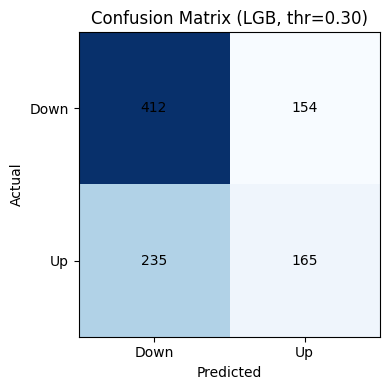

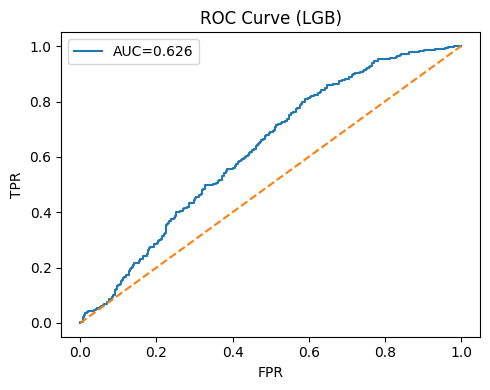

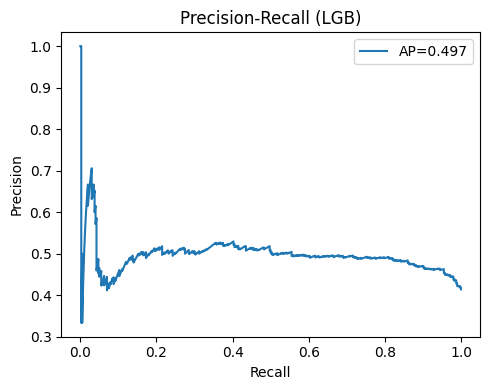

In [24]:
if not X.empty:
    cands = {
        'GB': (pred_gb, proba_gb, pipe_gb),
        'XGB': (pred_xgb, proba_xgb, rs_xgb.best_estimator_),
        'LGB': (pred_lgb, proba_lgb, rs_lgb.best_estimator_)
    }
    
    best_name, best_pred, best_proba, best_pipe, best_f1 = None, None, None, None, -1
    for name, (p, pr, model) in cands.items():
        f1 = f1_score(y_test, p)
        if f1 > best_f1:
            best_name, best_pred, best_proba, best_pipe, best_f1 = name, p, pr, model, f1
    
    print(f"\n--- Best Model Selection ---")
    print(f"Best model by default (0.5) threshold → {best_name} (F1={best_f1:.4f})")
    
    # Tune threshold for best F1 on holdout
    thresh_grid = np.linspace(0.3, 0.7, 41)
    best_thresh, best_f1_thr = 0.5, -1
    for t in thresh_grid:
        f1 = f1_score(y_test, (best_proba >= t).astype(int))
        if f1 > best_f1_thr:
            best_f1_thr, best_thresh = f1, t
            
    print(f"Best threshold for {best_name} → {best_thresh:.3f} (F1={best_f1_thr:.4f})")
    
    # --- Confusion Matrix @ Tuned Threshold ---
    cm = confusion_matrix(y_test, (best_proba >= best_thresh).astype(int))
    plt.figure(figsize=(4,4))
    plt.imshow(cm, cmap='Blues', aspect='auto')
    plt.title(f'Confusion Matrix ({best_name}, thr={best_thresh:.2f})')
    plt.xticks([0,1], ['Down','Up']); plt.yticks([0,1], ['Down','Up'])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.tight_layout()
    plt.savefig("gold_confusion_matrix.png")
    plt.show()
    
    # --- ROC Curve ---
    fpr, tpr, _ = roc_curve(y_test, best_proba)
    roc_auc = roc_auc_score(y_test, best_proba)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f'AUC={roc_auc:.3f}')
    plt.plot([0,1], [0,1], linestyle='--')
    plt.title(f'ROC Curve ({best_name})'); plt.xlabel('FPR'); plt.ylabel('TPR')
    plt.legend(); plt.tight_layout()
    plt.savefig("gold_roc_curve.png")
    plt.show()
    
    # --- Precision-Recall Curve ---
    prec, rec, _ = precision_recall_curve(y_test, best_proba)
    ap = average_precision_score(y_test, best_proba)
    plt.figure(figsize=(5,4))
    plt.plot(rec, prec, label=f'AP={ap:.3f}')
    plt.title(f'Precision-Recall ({best_name})'); plt.xlabel('Recall'); plt.ylabel('Precision')
    plt.legend(); plt.tight_layout()
    plt.savefig("gold_pr_curve.png")
    plt.show()

Feature Importance

Plot the most important features from the best performing model.

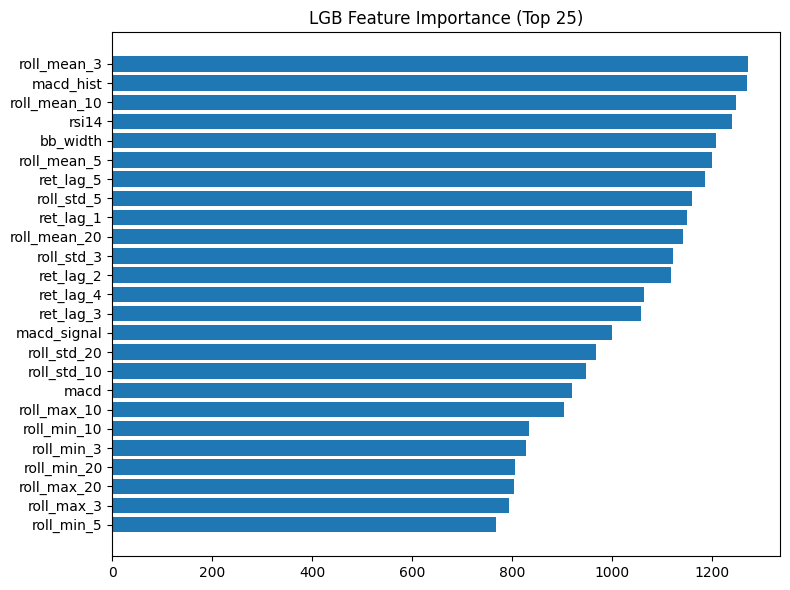

In [25]:
def plot_importance_from_pipeline(pipeline, feat_cols, title):
    model = pipeline.named_steps.get('model', pipeline)
    
    # Get importances from the model object inside the pipeline
    if hasattr(model, 'feature_importances_'):
        imp = model.feature_importances_
    elif hasattr(model, 'booster_') and hasattr(model.booster_, 'feature_importances_'): # for XGB
        imp = model.booster_.feature_importances_
    elif hasattr(model, 'feature_name_') and hasattr(model, 'feature_importances_'): # for LGBM
        imp = model.feature_importances_
    else:
        print(f"Could not extract feature_importances_ from {type(model)}")
        return
    
    # Create a pandas series for easier handling
    imp_series = pd.Series(imp, index=feat_cols)
    
    # Sort and take top 25
    imp_series = imp_series.sort_values(ascending=False).head(25)
    
    plt.figure(figsize=(8,6))
    plt.barh(imp_series.index[::-1], imp_series.values[::-1]) # Plot in descending order
    plt.title(title)
    plt.tight_layout()
    plt.savefig("gold_feature_importance.png")
    plt.show()

if not X.empty:
    plot_importance_from_pipeline(best_pipe, X.columns, f"{best_name} Feature Importance (Top 25)")

Final Prediction & Save Artifacts

Finally, refit the best model on ALL data and predict the next day's direction.

In [26]:
if not X.empty:
    print("\n--- Refitting model on all data for final prediction ---")
    
    # Refit the best pipeline on ALL available data (X, y)
    best_pipe.fit(X, y)
    
    # Get the features from the single last row
    last_X = X.iloc[[-1]]
    
    # Predict the probability of "Up"
    p_up = float(best_pipe.predict_proba(last_X)[:,1])
    
    # Make the final call using our tuned threshold
    pred = int(p_up >= best_thresh)
    direction = "UP 📈" if pred==1 else "DOWN 📉"
    
    print(f"\n--- Next-Day Projection ---")
    print(f"Model: {best_name}")
    print(f"Projection: {direction}")
    print(f"P(Up) = {p_up:.3f}  |  Decision Threshold = {best_thresh:.3f}")
    
    # Save the model and predictions
    model_filename = f"gold_direction_model_{best_name}.joblib"
    dump(best_pipe, model_filename)
    print(f"\nSaved best model to: {model_filename}")
    
    pred_df = pd.DataFrame({
        'date': feat['date'].iloc[split_idx:].values,
        'actual': y_test.values,
        f"pred_{best_name}@{best_thresh:.2f}": (best_proba >= best_thresh).astype(int),
        "proba_up": best_proba
    })
    pred_df.to_csv("holdout_predictions.csv", index=False)
    print("Saved holdout predictions to: holdout_predictions.csv")


--- Refitting model on all data for final prediction ---

--- Next-Day Projection ---
Model: LGB
Projection: DOWN 📉
P(Up) = 0.000  |  Decision Threshold = 0.300

Saved best model to: gold_direction_model_LGB.joblib
Saved holdout predictions to: holdout_predictions.csv
